# Stimulation onsets/offsets extraction for the EKG-VNS study
## Objective:
- have a csv file containing 'correct' stim onsets/offset. There should be two stimulation per day for each patient
- have a csv file reporting problematic dates per patient
## Steps:
- have box installed in the computer
- import util functions
- specify directory, target subjects, and output filenames (this is **important**!! otherwise overwriting happens)

## Notes:
- on mac, est 2hours per subj
- we skip corrupted file
- ignore the 'compressed blabla'

In [57]:
import sys
# !{sys.executable} -m pip install pandas numpy matplotlib seaborn scipy biosppy hrv-analysis py-ecg-detectors  # check requirement in the first run!

#@title Importing Modules
# system imports
import os
#import sys
import warnings
# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing 
from scipy import signal
from scipy.ndimage import label
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from scipy import ndimage
from scipy.stats import zscore
from scipy.signal import savgol_filter

# bio signal processing 
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values,get_time_domain_features
from ecgdetectors import Detectors

# misc
import warnings
import glob
from datetime import timedelta
import csv

import gzip
from scipy import signal
import datetime
from struct import pack, unpack_from, Struct



unpack_b = Struct('<b').unpack_from
unpack_w = Struct('<H').unpack_from
unpack_s = Struct('<h').unpack_from
unpack_f = Struct('<f').unpack_from
unpack_d = Struct('<d').unpack_from
unpack_dw = Struct('<L').unpack_from
pack_b = Struct('<b').pack
pack_w = Struct('<H').pack
pack_s = Struct('<h').pack
pack_f = Struct('<f').pack
pack_d = Struct('<d').pack
pack_dw = Struct('<L').pack


def unpack_str(buf, pos):
    strlen = unpack_dw(buf, pos)[0]
    pos += 4
    val = buf[pos:pos + strlen].decode('utf-8', 'ignore')
    pos += strlen
    return val, pos


def pack_str(s):
    sutf = s.encode('utf-8')
    return pack_dw(len(sutf)) + sutf


# 4 byte L (unsigned) l (signed)
# 2 byte H (unsigned) h (signed)
# 1 byte B (unsigned) b (signed)
def parse_fmt(fmt):
    if fmt == 1:
        return 'f', 4
    elif fmt == 2:
        return 'd', 8
    elif fmt == 3:
        return 'b', 1
    elif fmt == 4:
        return 'B', 1
    elif fmt == 5:
        return 'h', 2
    elif fmt == 6:
        return 'H', 2
    elif fmt == 7:
        return 'l', 4
    elif fmt == 8:
        return 'L', 4
    return '', 0


class VitalFile:
    def __init__(self, ipath, dtnames=None):
        self.load_vital(ipath, dtnames)

    def get_samples(self, dtname, interval=1):
        if not interval:
            return None

        trk = self.find_track(dtname)
        if not trk:
            return None

        # 리턴 할 길이
        nret = int(np.ceil((self.dtend - self.dtstart) / interval))

        if trk['type'] == 2:  # numeric track
            ret = np.full(nret, np.nan)  # create a dense array
            for rec in trk['recs']:  # copy values
                idx = int((rec['dt'] - self.dtstart) / interval)
                if idx < 0:
                    idx = 0
                elif idx > nret:
                    idx = nret
                ret[idx] = rec['val']
            return ret
        elif trk['type'] == 1:  # wave track
            srate = trk['srate']
            recs = trk['recs']

            # 자신의 srate 만큼 공간을 미리 확보
            nsamp = int(np.ceil((self.dtend - self.dtstart) * srate))
            ret = np.full(nsamp, np.nan)

            # 실제 샘플을 가져와 채움
            for rec in recs:
                sidx = int(np.ceil((rec['dt'] - self.dtstart) * srate))
                eidx = sidx + len(rec['val'])
                srecidx = 0
                erecidx = len(rec['val'])
                if sidx < 0:  # self.dtstart 이전이면
                    srecidx -= sidx
                    sidx = 0
                if eidx > nsamp:  # self.dtend 이후이면
                    erecidx -= (eidx - nsamp)
                    eidx = nsamp
                ret[sidx:eidx] = rec['val'][srecidx:erecidx]

            # gain offset 변환
            if trk['fmt'] > 2:  # 1: float, 2: double
                ret *= trk['gain']
                ret += trk['offset']

            # 리샘플 변환
            if srate != int(1 / interval + 0.5):
                ret = np.take(ret, np.linspace(0, nsamp - 1, nret).astype(np.int64))

            return ret

        return None

    def find_track(self, dtname):
        dname = None
        tname = dtname
        if dtname.find('/') != -1:
            dname, tname = dtname.split('/')

        for trk in self.trks.values():  # find track
            if trk['name'] == tname:
                did = trk['did']
                if did == 0 or not dname:
                    return trk                    
                if did in self.devs:
                    dev = self.devs[did]
                    if 'name' in dev and dname == dev['name']:
                        return trk

        return None

    def save_vital(self, ipath, compresslevel=1):
        f = gzip.GzipFile(ipath, 'wb', compresslevel=compresslevel)

        # save header
        if not f.write(b'VITA'):  # check sign
            return False
        if not f.write(pack_dw(3)):  # version
            return False
        if not f.write(pack_w(10)):  # header len
            return False
        if not f.write(self.header):  # save header
            return False

        # save devinfos
        for did, dev in self.devs.items():
            if did == 0: continue
            ddata = pack_dw(did) + pack_str(dev['name']) + pack_str(dev['type']) + pack_str(dev['port'])
            if not f.write(pack_b(9) + pack_dw(len(ddata)) + ddata):
                return False

        # save trkinfos
        for tid, trk in self.trks.items():
            ti = pack_w(tid) + pack_b(trk['type']) + pack_b(trk['fmt']) + pack_str(trk['name']) \
                + pack_str(trk['unit']) + pack_f(trk['mindisp']) + pack_f(trk['maxdisp']) \
                + pack_dw(trk['col']) + pack_f(trk['srate']) + pack_d(trk['gain']) + pack_d(trk['offset']) \
                + pack_b(trk['montype']) + pack_dw(trk['did'])
            if not f.write(pack_b(0) + pack_dw(len(ti)) + ti):
                return False

            # save recs
            for rec in trk['recs']:
                rdata = pack_w(10) + pack_d(rec['dt']) + pack_w(tid)  # infolen + dt + tid (= 12 bytes)
                if trk['type'] == 1:  # wav
                    rdata += pack_dw(len(rec['val'])) + rec['val'].tobytes()
                elif trk['type'] == 2:  # num
                    fmtcode, fmtlen = parse_fmt(trk['fmt'])
                    rdata += pack(fmtcode, rec['val'])
                elif trk['type'] == 5:  # str
                    rdata += pack_dw(0) + pack_str(rec['val'])

                if not f.write(pack_b(1) + pack_dw(len(rdata)) + rdata):
                    return False

        # save trk order
        if hasattr(self, 'trkorder'):
            cdata = pack_b(5) + pack_w(len(self.trkorder)) + self.trkorder.tobytes()
            if not f.write(pack_b(6) + pack_dw(len(cdata)) + cdata):
                return False

        f.close()
        return True

    def load_vital(self, ipath, dtnames=None):
        if isinstance(dtnames, str):
            if dtnames.find(','):
                dtnames = dtnames.split(',')
            else:
                dtnames = [dtnames]

        # dtnames: 로딩을 원하는 dtname 의 리스트. dtnames가 None 이면 트랙 목록만 읽혀짐
        f = gzip.GzipFile(ipath, 'rb')

        # parse header
        if f.read(4) != b'VITA':  # check sign
            return False

        f.read(4)  # file version

        buf = f.read(2)
        if buf == b'':
            return False

        headerlen = unpack_w(buf, 0)[0]
        self.header = f.read(headerlen)  # skip header
        self.dgmt = unpack_s(self.header, 0)[0]  # ut - dgmt = localtime

        # parse body
        self.devs = {0: {}}  # device names. did = 0 represents the vital recorder
        self.trks = {}
        self.dtstart = 0
        self.dtend = 0

        try:
            sel_tids = set()
            while True:
                buf = f.read(5)
                if buf == b'':
                    break
                pos = 0

                packet_type = unpack_b(buf, pos)[0]; pos += 1
                packet_len = unpack_dw(buf, pos)[0]; pos += 4

                buf = f.read(packet_len)
                if buf == b'':
                    break
                pos = 0

                if packet_type == 9:  # devinfo
                    did = unpack_dw(buf, pos)[0]; pos += 4
                    devtype, pos = unpack_str(buf, pos)
                    name, pos = unpack_str(buf, pos)
                    if len(buf) > pos + 4:  # port는 없을 수 있다
                        port, pos = unpack_str(buf, pos)
                    if not name:
                        name = devtype
                    self.devs[did] = {'name': name, 'type': devtype, 'port': port}
                elif packet_type == 0:  # trkinfo
                    did = col = 0
                    montype = unit = ''
                    gain = offset = srate = mindisp = maxdisp = 0.0
                    tid = unpack_w(buf, pos)[0]; pos += 2
                    trktype = unpack_b(buf, pos)[0]; pos += 1
                    fmt = unpack_b(buf, pos)[0]; pos += 1
                    tname, pos = unpack_str(buf, pos)

                    if packet_len > pos:
                        unit, pos = unpack_str(buf, pos)
                    if packet_len > pos:
                        mindisp = unpack_f(buf, pos)[0]
                        pos += 4
                    if packet_len > pos:
                        maxdisp = unpack_f(buf, pos)[0]
                        pos += 4
                    if packet_len > pos:
                        col = unpack_dw(buf, pos)[0]
                        pos += 4
                    if packet_len > pos:
                        srate = unpack_f(buf, pos)[0]
                        pos += 4
                    if packet_len > pos:
                        gain = unpack_d(buf, pos)[0]
                        pos += 8
                    if packet_len > pos:
                        offset = unpack_d(buf, pos)[0]
                        pos += 8
                    if packet_len > pos:
                        montype = unpack_b(buf, pos)[0]
                        pos += 1
                    if packet_len > pos:
                        did = unpack_dw(buf, pos)[0]
                        pos += 4

                    dname = ''
                    if did and did in self.devs:
                        if did and did in self.devs:
                            dname = self.devs[did]['name']
                        dtname = dname + '/' + tname
                    else:
                        dtname = tname

                    if dtnames:  # 사용자가 특정 트랙만 읽으라고 했을 때
                        matched = False
                        if dtname in dtnames:  # dtname (현재 읽고 있는 트랙명)이 dtnames에 지정된 것과 정확히 일치할 때
                            matched = True
                        else:
                            for sel_dtname in dtnames:
                                if dtname.endswith('/' + sel_dtname) or (dname + '/*' == sel_dtname): # 트랙명만 지정 or 특정 장비의 모든 트랙일 때
                                    matched = True
                                    sel_tids.add(tid)
                                    break
                                    
                        if not matched:
                            continue
                        sel_tids.add(tid)  # 앞으로는 sel_tids 에서 체크한다

                    # dtnames가 None 이거나 사용자가 원하는 sel 일 때
                    self.trks[tid] = {'name': tname, 'dtname': dtname, 'type': trktype, 'fmt': fmt, 'unit': unit, 'srate': srate,
                                      'mindisp': mindisp, 'maxdisp': maxdisp, 'col': col, 'montype': montype,
                                      'gain': gain, 'offset': offset, 'did': did, 'recs': []}
                elif packet_type == 1:  # rec
                    infolen = unpack_w(buf, pos)[0]; pos += 2
                    dt = unpack_d(buf, pos)[0]; pos += 8
                    tid = unpack_w(buf, pos)[0]; pos += 2
                    pos = 2 + infolen

                    if self.dtstart == 0 or dt < self.dtstart:
                        self.dtstart = dt
                    
                    # TODO: dtrec end 는 다를 수 있음 wav 읽어서 nsamp 로딩해야함
                    if dt > self.dtend:
                        self.dtend = dt

                   # if not dtnames:  # dtnames 가 None 이면 트랙 목록만 읽혀짐
                    #    continue

                    if tid not in self.trks:  # 이전 정보가 없는 트랙이거나
                        continue
                 #   if tid not in sel_tids:  # 사용자가 트랙 지정을 한 경우
                 #       continue

                    trk = self.trks[tid]  

                    fmtlen = 4
                    # gain, offset 변환은 하지 않은 raw data 상태로만 로딩한다.
                    # 항상 이 변환이 필요하지 않기 때문에 변환은 get_samples 에서 나중에 한다.
                    if trk['type'] == 1:  # wav
                        fmtcode, fmtlen = parse_fmt(trk['fmt'])
                        nsamp = unpack_dw(buf, pos)[0]; pos += 4
                        samps = np.ndarray((nsamp,), buffer=buf, offset=pos, dtype=np.dtype(fmtcode)); pos += nsamp * fmtlen
                        trk['recs'].append({'dt': dt, 'val': samps})
                    elif trk['type'] == 2:  # num
                        fmtcode, fmtlen = parse_fmt(trk['fmt'])
                        val = unpack_from(fmtcode, buf, pos)[0]; pos += fmtlen
                        trk['recs'].append({'dt': dt, 'val': val})
                    elif trk['type'] == 5:  # str
                        pos += 4  # skip
                        s, pos = unpack_str(buf, pos)
                        trk['recs'].append({'dt': dt, 'val': s})
                elif packet_type == 6:  # cmd
                    cmd = unpack_b(buf, pos)[0]; pos += 1
                    if cmd == 6:  # reset events
                        evt_trk = self.find_track('/EVENT')
                        if evt_trk:
                            evt_trk['recs'] = []
                    elif cmd == 5:  # trk order
                        cnt = unpack_w(buf, pos)[0]; pos += 2
                        self.trkorder = np.ndarray((cnt,), buffer=buf, offset=pos, dtype=np.dtype('H')); pos += cnt * 2

        except EOFError as error:
            print(error)
            pass

        # sorting tracks
        # for trk in self.trks.values():
        #     trk['recs'].sort(key=lambda r:r['dt'])

        f.close()
        return True


def load_trk(tid, interval=1):
    try:
        url = 'https://api.vitaldb.net/' + tid
        dtvals = pd.read_csv(url, na_values='-nan(ind)').values
    except:
        return np.empty(0)

    if len(dtvals) == 0:
        return np.empty(0)
    
    dtvals[:,0] /= interval  # convert time to row
    nsamp = int(np.nanmax(dtvals[:,0])) + 1  # find maximum index (array length)
    ret = np.full(nsamp, np.nan)  # create a dense array
    
    if np.isnan(dtvals[:,0]).any():  # wave track
        if nsamp != len(dtvals):  # resample
            ret = np.take(dtvals[:,1], np.linspace(0, len(dtvals) - 1, nsamp).astype(np.int64))
        else:
            ret = dtvals[:,1]
    else:  # numeric track
        for idx, val in dtvals:  # copy values
            ret[int(idx)] = val

    return ret


def load_trks(tids, interval=1):
    trks = []
    maxlen = 0
    for tid in tids:
        trk = load_trk(tid, interval)
        trks.append(trk)
        if len(trk) > maxlen:
            maxlen = len(trk)
    if maxlen == 0:
        return np.empty(0)
    ret = np.full((maxlen, len(tids)), np.nan)  # create a dense array
    for i in range(len(tids)):  # copy values
        ret[:len(trks[i]), i] = trks[i]
    return ret

def vital_recs(ipath, dtnames, interval=0.3, return_timestamp=False, return_datetime=False):
    if not dtnames:
        return []

    # 
    if isinstance(dtnames, str):
        if dtnames.find(',') != -1:
            dtnames = dtnames.split(',')
        else:
            dtnames = [dtnames]

    vf = VitalFile(ipath, dtnames)

    nrows = int(np.ceil((vf.dtend - vf.dtstart) / interval))
    if not nrows:
        return []

    ret = []
    for dtname in dtnames:
        col = vf.get_samples(dtname, interval)
        if col is None:
            col = np.full(nrows, np.nan)
        ret.append(col)
    if not ret:
        return []

    # return time column
    if return_datetime: # in this case, numpy array with object type will be returned
        tzi = datetime.timezone(datetime.timedelta(minutes=-vf.dgmt))
        dts = datetime.datetime.fromtimestamp(vf.dtstart, tzi)
        dte = dts + datetime.timedelta(seconds=len(ret[0]))
        ret.insert(0, [dts + datetime.timedelta(seconds=i*interval) for i in range(len(ret[0]))])
    elif return_timestamp:
        ret.insert(0, np.arange(vf.dtstart, vf.dtend, interval))

    ret = np.transpose(ret)

    return ret

def vital_trks(ipath):
    # 트랙 목록만 읽어옴
    ret = []
    vf = VitalFile(ipath)
    for trk in vf.trks.values():
        tname = trk['name']
        dname = ''
        did = trk['did']
        if did in vf.devs:
            dev = vf.devs[did]
            if 'name' in dev:
                dname = dev['name']
        ret.append(dname + '/' + tname)
    return ret


# api files
dftrks = None

def load_case(tnames, caseid=None, interval=1):
    global dftrks

    if not caseid:
        return None
    if dftrks is None:
        dftrks = pd.read_csv("https://api.vitaldb.net/trks")

    tids = []
    for tname in tnames:
        tid = dftrks[(dftrks['caseid'] == caseid) & (dftrks['tname'] == tname)]['tid'].values[0]
        tids.append(tid)
    
    return load_trks(tids, interval)


def load_cases(tnames, caseids=None, interval=1, maxcases=1):
    global dftrks

    # find the caseids which contains tnames
    if not isinstance(tnames, list):
        if isinstance(tnames, str):
            tnames = tnames.split(',')
        else:
            return None

    if interval == 0:
        return None

    if not caseids:
        if dftrks is None:
            dftrks = pd.read_csv("https://api.vitaldb.net/trks")

        # filter cases which don't have all tnames
        caseids = None
        for tname in tnames:
            matched = set(dftrks[dftrks['tname'] == tname]['caseid'])
            if caseids is None:
                caseids = matched
            else:
                caseids = caseids & matched
        
    cases = {}
    for caseid in caseids:
        case = load_case(tnames, caseid, interval)
        if case is None:
            continue
        if len(case) == 0:
            continue
        cases[caseid] = case
        if len(cases) >= maxcases:
            break

    return cases

#@title class that contains our vital data for future use

class VitalDBData:
    def __init__(self,vital_file):
        vital_data = VitalFile(vital_file)
        ecg_settings = vital_data.find_track('ECG_I')
        self.sampling_rate = ecg_settings['srate']
        self.ecg_I = vital_data.get_samples('ECG_I', 1/self.sampling_rate)
        self.ecg_II = vital_data.get_samples('ECG_II', 1/self.sampling_rate)
        self.ecg_III = vital_data.get_samples('ECG_III', 1/self.sampling_rate)
        self.ch1 = vital_data.get_samples('CH1', 1/self.sampling_rate)
#         self.ch1_normalized=zscore(self.ch1)
        self.starttime = datetime.datetime.fromtimestamp(vital_data.dtstart)
        self.endtime = datetime.datetime.fromtimestamp(vital_data.dtend)

#         self.__loadCh1Info(vital_data,mu,sigm,20)
        self.__removeNaNs()
        
    def __removeNaNs(self):
        nan_time = np.isnan(self.ecg_I)
        self.ecg_I[nan_time]=0
        self.ecg_II[nan_time]=0
        self.ecg_III[nan_time]=0
        self.ch1[nan_time]=0
        self.t = np.arange(len(self.ecg_I))/(self.sampling_rate)
        
def itpl_data_close_to0(data, lower_bound):
    '''
    data should be a positive numpy array
    return data where both nan and value close to zero become zero
    
    e.g.
    a = np.array([100, 200 ,0, 1, 0,8 ,52, 0,5])
    itpl_data_close_to0(a,2)
    
    need help: g.tan@wustl.edu
    '''
    data[data < lower_bound] = 0
    data[data == np.nan] = 0
    zero_indices = data==0
    interpolated = np.interp(zero_indices.nonzero()[0], (~zero_indices).nonzero()[0], data[~zero_indices])
    data[zero_indices.nonzero()[0]] = interpolated
    return data

import numpy

def smooth(x,window_len=1000,window='hanning'):

    if x.ndim != 1:
        raise ValueError 

    if x.size < window_len:
        raise ValueError


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def unit_step(signal, condition):
    return np.where(signal > condition, 1, 0)

def err_analysis (report_error, subj, vit_dir, err_msg, timestamps_1day, stim_ch_1day_raw, stim_ch_1day, stim_detected, fig_fName):
    report_error['subject'].append(subj)
    report_error['date'].append(vit_dir)
    report_error['err_msg'].append(err_msg)
    fig = plt.figure(figsize=(18,8))
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312, sharex=ax1)
    ax3 = plt.subplot(313, sharex=ax1)
    y_stim4viz = np.zeros(timestamps_1day.shape[0])
    y_stim4viz[1:(20 * 60 * 500)] = 1
    ax1.plot(timestamps_1day, stim_ch_1day_raw, 'b')
    ax1.legend(['raw_stim_ch'])
    ax2.plot(timestamps_1day,y_stim4viz,'g', label='eg_20min')
    ax2.plot(timestamps_1day, stim_ch_1day, 'b', label='thresholded_stim')
    ax2.set_ylim([-0.2,1.2])
    ax2.legend(loc='upper right')
    ax3.plot(timestamps_1day, stim_detected, 'r', label='identified_stim')
    ax3.set_ylim([-0.2,1.2])
    ax3.legend(loc='upper right')
    fig.savefig(fig_fName)
    plt.clf()
    return report_error

In [ ]:
# PARAMETERS
lower_bound = 1e-3 # data in stim ch lower than this bound will be interpolated, modified inline
interval_boundary = 30 * 500  # 30 seconds, used in stim identification algo
padding_value = 100 * 500  # must > interval boundary
tol_session_t = 22 * 500 * 60  #
# savgol_wl = 100  # window length, ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# savgol_mode = 'interp', savgol filter cost too much memories, not a good way
err_report_fName = os.path.join(search_dir, 'report', 'error_report.csv')  # change this (right side of '=') if run in different computer
stim_time_fName = os.path.join(search_dir, 'stim_time_gt.csv')  # change this if run in different computer
stim_time_questionable_fName = os.path.join(search_dir, 'stim_time_questionable_gt.csv')  # change this if run in different computer
search_dir = '/Users/ganshengt/Box/taVNS_clinical'  # change this if run in different computer

vit_subject_dir= os.listdir(search_dir)
vit_subject_dir = ['2020012']  # please specify if you want to run the script on a subgroup of subjects

stim_names = {'subject' : [],
              'date':[],
              'time' : [],
              'event': []}
stim_names_questionable = {'subject' : [],
              'date':[],
              'time' : [],
              'event': []}
report_error = {'subject' : [],
              'date' : [],
              'err_msg': []}

for i,subj in enumerate(vit_subject_dir): #looping through taVNS folder, subj is patient
    if not subj.isnumeric():
        continue
    mu = []
    var=[]
    thresh = []
    vit_files_dir = os.listdir(os.path.join(search_dir,subj))
    
#     vit_files_dir = ['210714']  # 4 test, specify date that you want to run the script

    for vit_dir in vit_files_dir: #looping through the days for patient
        if not os.path.isdir(os.path.join(search_dir,subj,vit_dir)):
            continue
        vit_files=os.scandir(os.path.join(search_dir,subj,vit_dir))
        stim_ch_1day = []
        timestamps_1day = []
#         date = parsed_file.starttime.date()  # use the file name
        for j,vital_filename in enumerate(vit_files): # looping through file for that day
            if not vital_filename.name.endswith('.vital'):  # jump over the tks file
                continue
            vital_file = os.path.join(search_dir,subj,vit_dir,vital_filename)
            try: 
                vital_data = VitalFile(vital_file)
                ch1 = vital_data.get_samples('CH1', 1/500.0)  # we are interested in the stim ch and timestamps
                if ch1 is not None:
                    parsed_file=VitalDBData(vital_file)
                    stim_ch_1day += list(parsed_file.ch1)
                    starttime_s = datetime.timedelta(hours=parsed_file.starttime.hour, minutes=parsed_file.starttime.minute, seconds=parsed_file.starttime.second, 
                                                     microseconds=parsed_file.starttime.microsecond).total_seconds()
                    timestamps_1day += list(starttime_s + parsed_file.t)
                    
            except:
                report_error['subject'].append(subj)
                report_error['date'].append(vit_dir)
                report_error['err_msg'].append('possible file corruption, loading error for' + vital_filename.name)
                pass
        # switch to np for computational convenience
        stim_ch_1day_raw = np.array(stim_ch_1day).copy()
        stim_ch_1day = np.array(np.absolute(stim_ch_1day))
        timestamps_1day = np.array(timestamps_1day)
#         stim_ch_1day = itpl_data_close_to0(stim_ch_1day, lower_bound)
        stim_ch_1day = unit_step(stim_ch_1day, np.max(stim_ch_1day)/2)
        assert stim_ch_1day.shape == timestamps_1day.shape, 'mismatch in length, bugs?'
        
        if np.sum(stim_ch_1day)==0:
            report_error['subject'].append(subj)
            report_error['date'].append(vit_dir)
            report_error['err_msg'].append('no signal in stim ch')
        else:
            indices_relmax = signal.argrelmax(stim_ch_1day)[0]
            # identify onsets and offsets by the interval length between relative max points
            indices_relmax_diff = np.diff(indices_relmax)
            indices_relmax_diff_l_padding = np.insert(indices_relmax_diff, 0, padding_value)  # padding in the left 
            indices_relmax_diff_r_padding = np.insert(indices_relmax_diff, indices_relmax_diff.shape[0], padding_value)  # padding in the right 
            indices_has_neighbor_l = indices_relmax_diff_l_padding < interval_boundary  # boolean array showing indices that have neighbor on their left 
            indices_has_neighbor_r = indices_relmax_diff_r_padding < interval_boundary
            # indices_inside_stim = np.logical_and(indices_has_neighbor_l, indices_has_neighbor_r)
            stim_onset = indices_relmax[np.logical_and(indices_has_neighbor_r, ~indices_has_neighbor_l)]  # stim onsets have neighbors on their right side but not left
            stim_offset = indices_relmax[np.logical_and(indices_has_neighbor_l, ~indices_has_neighbor_r)]  # stim onsets have neighbors on their right side but not left
            stim_detected = np.zeros(timestamps_1day.shape[0])
            fig_fName = os.path.join(search_dir, 'report', subj + '_' + vit_dir + '_stim.jpeg')
            for i in range(stim_onset.shape[0]):
                stim_detected[stim_onset[i]:stim_offset[i]]=1

            if ((stim_offset - stim_onset) > tol_session_t).any(): # stim lasts more than 22 minutes, report error, we save onsets anyway for reference
                report_error = err_analysis(report_error, subj, vit_dir, 'identified stim session more than 21 minutes', timestamps_1day, 
                                            stim_ch_1day_raw, stim_ch_1day, stim_detected, fig_fName)
                for onset in stim_onset:
                    stim_names_questionable['subject'].append(subj)
                    stim_names_questionable['date'].append(vit_dir)
                    stim_names_questionable['time'].append(timestamps_1day[onset])
                    stim_names_questionable['event'].append('stim_onset')
                for offset in stim_offset:
                    stim_names_questionable['subject'].append(subj)
                    stim_names_questionable['date'].append(vit_dir)
                    stim_names_questionable['time'].append(timestamps_1day[onset])
                    stim_names_questionable['event'].append('stim_offset')
                    
            elif stim_onset.shape[0] + stim_offset.shape[0] != 4:  # false detection 
                report_error = err_analysis(report_error, subj, vit_dir, 'detected more/less than 2 stimulation within one day', timestamps_1day, 
                                            stim_ch_1day_raw, stim_ch_1day, stim_detected, fig_fName)
                for onset in stim_onset:
                    stim_names_questionable['subject'].append(subj)
                    stim_names_questionable['date'].append(vit_dir)
                    stim_names_questionable['time'].append(timestamps_1day[onset])
                    stim_names_questionable['event'].append('stim_onset')
                for offset in stim_offset:
                    stim_names_questionable['subject'].append(subj)
                    stim_names_questionable['date'].append(vit_dir)
                    stim_names_questionable['time'].append(timestamps_1day[onset])
                    stim_names_questionable['event'].append('stim_offset')

            else:
                for onset in stim_onset:
                    stim_names['subject'].append(subj)
                    stim_names['date'].append(vit_dir)
                    stim_names['time'].append(timestamps_1day[onset])
                    stim_names['event'].append('stim_onset')
                for offset in stim_offset:
                    stim_names['subject'].append(subj)
                    stim_names['date'].append(vit_dir)
                    stim_names['time'].append(timestamps_1day[offset])
                    stim_names['event'].append('stim_offset')
                
df_report_error = pd.DataFrame(report_error)
df_report_error.to_csv(err_report_fName)
df_stim_time = pd.DataFrame(stim_names)
df_stim_time.to_csv(stim_time_fName)
df_stim_time_questionable = pd.DataFrame(stim_names_questionable)
df_stim_time_questionable.to_csv(stim_time_questionable_fName)

Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed

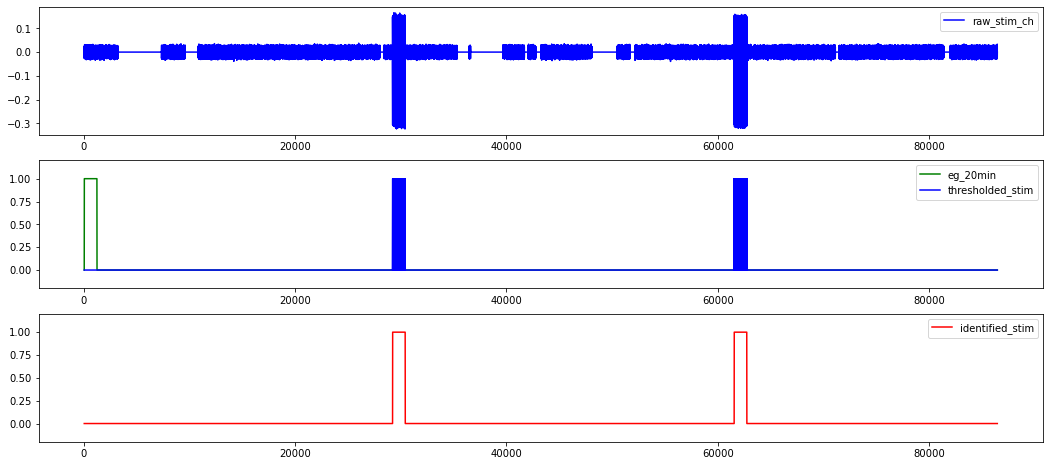

## End of script, scripts below are for visualization

Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed file ended before the end-of-stream marker was reached
Compressed

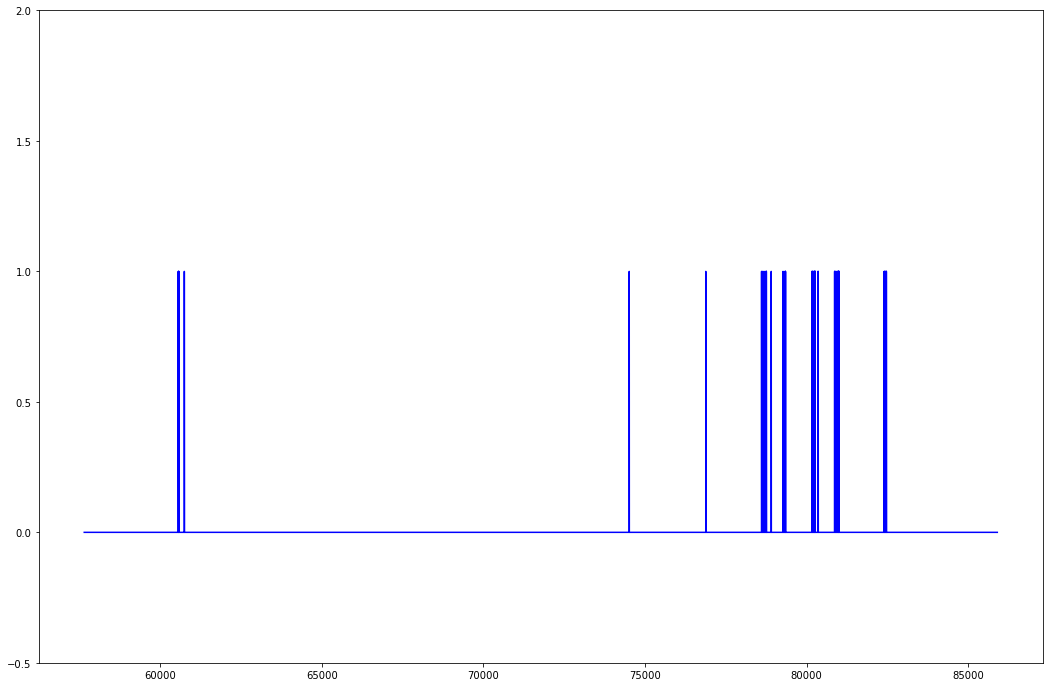

In [13]:
# manual inspection of the stim ch
# PARAMETERS
lower_bound = 1e-3 # data in stim ch lower than this bound will be interpolated, modified inline
interval_boundary = 30 * 500  # 30 seconds, used in stim identification algo
padding_value = 100 * 500  # must > interval boundary
tol_session_t = 22 * 500 * 60  #
# savgol_wl = 100  # window length, ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# savgol_mode = 'interp', savgol filter cost too much memories, not a good way

search_dir = '/Users/ganshengt/Box/taVNS_clinical'
subj = '2020012'
vit_dir = '210712'
    

vit_files=os.scandir(os.path.join(search_dir,subj,vit_dir))
stim_ch_1day = []
timestamps_1day = []
#         date = parsed_file.starttime.date()  # use the file name
for j,vital_filename in enumerate(vit_files): # looping through file for that day
    if not vital_filename.name.endswith('.vital'):  # jump over the tks file
        continue
    vital_file = os.path.join(search_dir,subj,vit_dir,vital_filename)
    try: 
        vital_data = VitalFile(vital_file)
        ch1 = vital_data.get_samples('CH1', 1/500.0)  # we are interested in the stim ch and timestamps
        if ch1 is not None:
            parsed_file=VitalDBData(vital_file)
            stim_ch_1day += list(parsed_file.ch1)
            starttime_s = datetime.timedelta(hours=parsed_file.starttime.hour, minutes=parsed_file.starttime.minute, seconds=parsed_file.starttime.second, 
                                             microseconds=parsed_file.starttime.microsecond).total_seconds()
            timestamps_1day += list(starttime_s + parsed_file.t)

    except:
        report_error['subject'].append(subj)
        report_error['date'].append(vit_dir)
        report_error['err_msg'].append('possible file corruption, loading error for' + vital_filename.name)
        pass
# switch to np for computational convenience
stim_ch_1day = np.array(np.absolute(stim_ch_1day))
timestamps_1day = np.array(timestamps_1day)
#         stim_ch_1day = itpl_data_close_to0(stim_ch_1day, lower_bound)
stim_ch_1day = unit_step(stim_ch_1day, np.max(stim_ch_1day)/2)

indices_relmax = signal.argrelmax(stim_ch_1day)[0]
# identify onsets and offsets by the interval length between relative max points
indices_relmax_diff = np.diff(indices_relmax)
indices_relmax_diff_l_padding = np.insert(indices_relmax_diff, 0, padding_value)  # padding in the left 
indices_relmax_diff_r_padding = np.insert(indices_relmax_diff, indices_relmax_diff.shape[0], padding_value)  # padding in the right 
indices_has_neighbor_l = indices_relmax_diff_l_padding < interval_boundary  # boolean array showing indices that have neighbor on their left 
indices_has_neighbor_r = indices_relmax_diff_r_padding < interval_boundary
# indices_inside_stim = np.logical_and(indices_has_neighbor_l, indices_has_neighbor_r)
stim_onset = indices_relmax[np.logical_and(indices_has_neighbor_r, ~indices_has_neighbor_l)]  # stim onsets have neighbors on their right side but not left
stim_offset = indices_relmax[np.logical_and(indices_has_neighbor_l, ~indices_has_neighbor_r)]  # stim onsets have neighbors on their right side but not left
stim_detected = np.zeros(timestamps_1day.shape[0])
for i in range(stim_onset.shape[0]):
    stim_detected[stim_onset[i]:stim_offset[i]]=1
fig = plt.figure(figsize=(18,8))
plt.ylim([-0.2,1.2])
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)
ax1.plot(timestamps_1day, stim_ch_1day, 'b')
y_stim4viz = np.zeros(timestamps_1day.shape[0])
y_stim4viz[1:(20 * 60 * 500)] = 1
ax1.plot(timestamps_1day,y_stim4viz,'g')
ax1.legend(['raw_stim_ch', 'eg_20minute'])
ax2.plot(timestamps_1day, stim_detected, 'r')
ax2.legend(['identified_stim'], loc ='lower right')

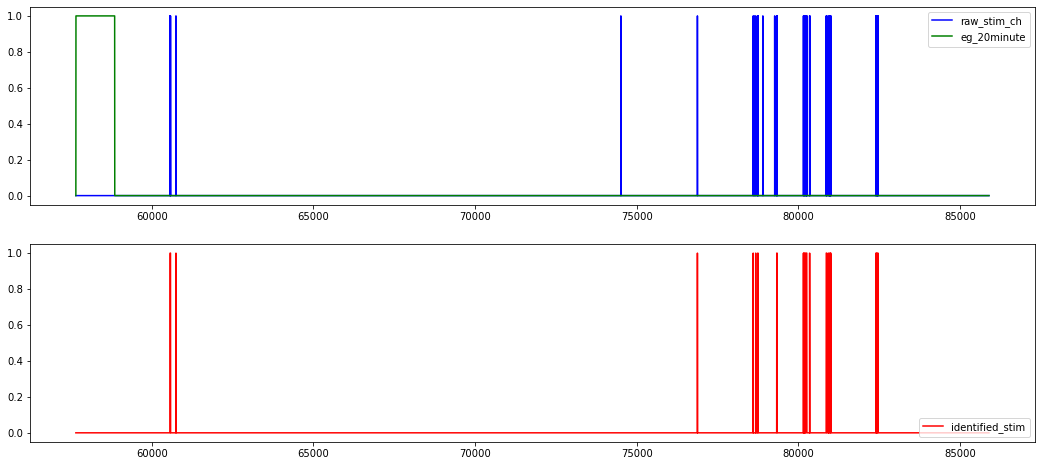